#  微小图像数据集

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

 CIFAR-10 由60000 张微小的（32 像素×32 像素）RGB 图像组成，是一类重要的数据集！
飞机（0）、汽车（1）、鸟（2）、猫（3）、鹿（4）、狗（5）、青蛙（6）、马（7）、船（8）和卡车（9）它很好地满足了我们的学习目的！



### 1 我们将使用TorchVision 模块自动下载数据集，并将其作为一组PyTorch 张量加载。

数据集子模块为我们提供了对最流行的计算机视觉数据集的预存储访问，如MNIST、Fashion-MNIST、CIFAR-100.

In [22]:
from torchvision import datasets
data_path = 'D:\深度学习课件（刘）\PPT 2023春\epxeriment_mnext'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # <2>

Files already downloaded and verified
Files already downloaded and verified


给CIFAR10()函数的第1 个参数是数据的下载位置；第2 个参数指定我们对训练集还是验证集感兴趣；第3 个参数表示如果在第1 个参数指定的位置找不到数据，我们是否允许PyTorch下载数据。

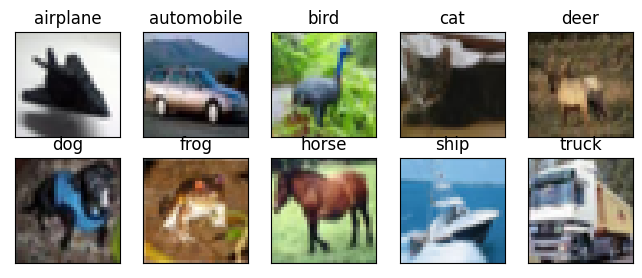

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

### 2 Dataset 类
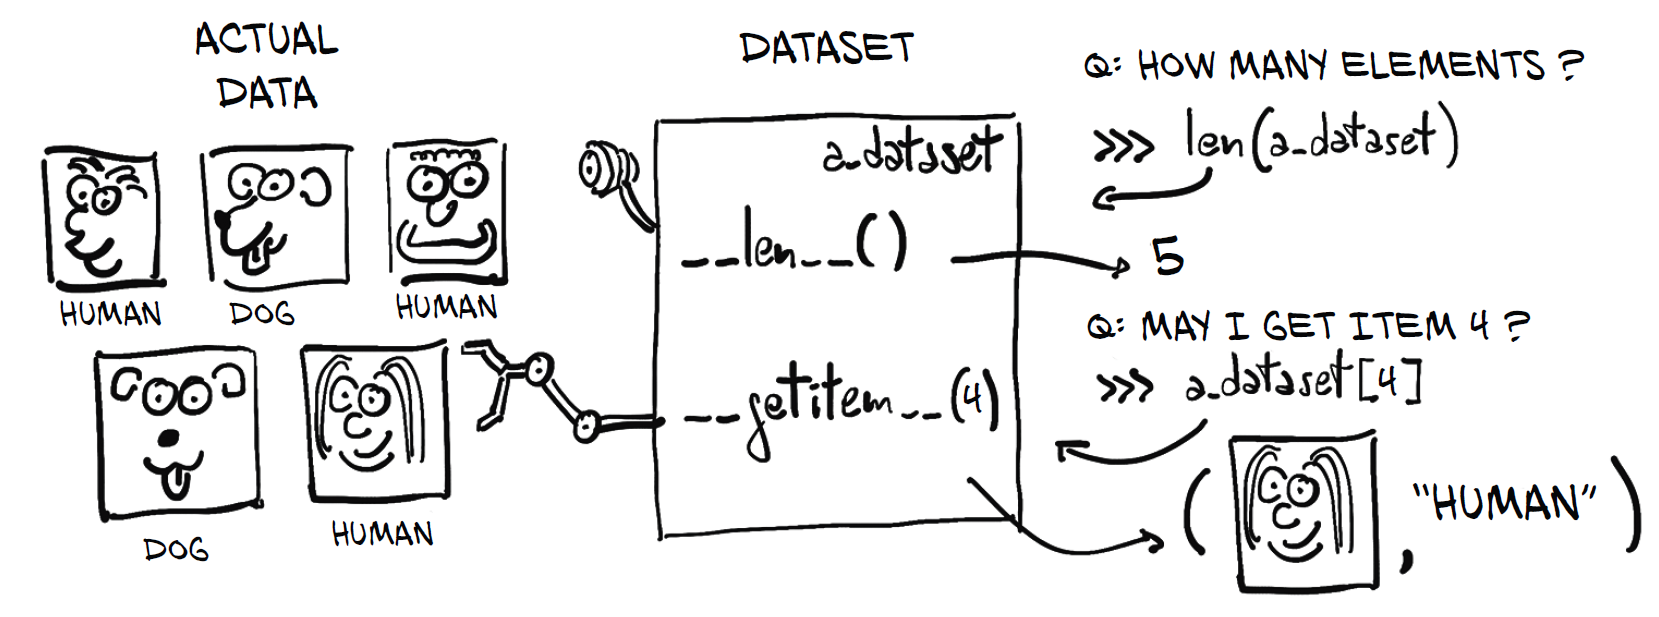
Dataset 对象的概念：它提供了对其进行统一访问的函数__len__()和__getitem__()

In [23]:
len(cifar10)

50000

In [25]:
img, label = cifar10[99]
img, label, class_names[label]  #img=PIL（Python Imaging Library，Python图像库）图像

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

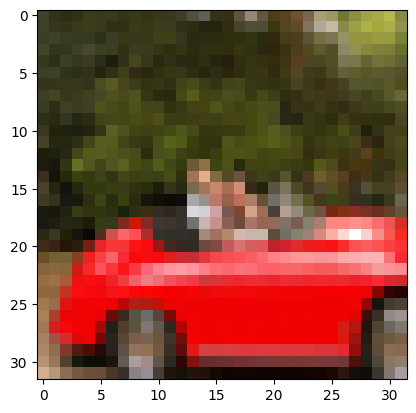

In [26]:
#data.CIFAR10 是RGB PIL 图像的一个实例
plt.imshow(img)
plt.show()

### 3 Dataset 变换我

In [8]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

ToTensor对象，它将NumPy数组和PIL图像变换为张量。
它还将输出张量的尺寸设置为C×H×W（通道、高度、宽度）。
下面试试ToTensor变换，一旦ToTensor被实例化，就可以像调用函数一样调用它，以PIL
图像作为参数，返回一个张量作为输出。

In [27]:
from torchvision import transforms

to_tensor = transforms.ToTensor() # 定义变换函数
img_t = to_tensor(img)            # 调用变换函数
img_t.shape                       # 显示变换后的数据格式

torch.Size([3, 32, 32])

图像已变换为3×32×32 的张量，即一个有3 个通道（RGB）的32×32 的图像。注意，标签
没有发生任何变化，它仍然是一个整数。

In [10]:
#可以将变换直接作为参数传递给dataset.CIFAR10，后面会经常看到这种调用方法
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [28]:
img_t, _ = tensor_cifar10[99]  # 把PIL变换成张量数，_ 代表标签，不输出
type(img_t)                    # 查看图片类型

torch.Tensor

In [12]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [13]:
# 原始PIL 图像中的值为0～255（每个通道8位），而ToTensor变换将数据变换为每个通道的
# 32位浮点数，将值缩小为0.0～1.0。让我们来验证一下：
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

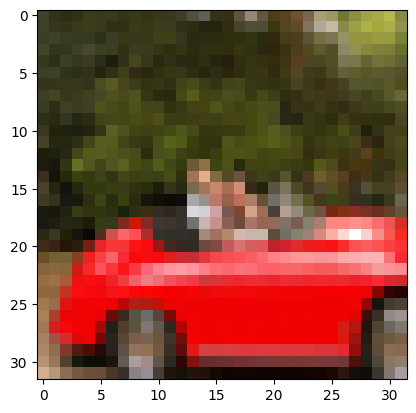

In [14]:
plt.imshow(img_t.permute(1, 2, 0))  #  将轴的顺序由C×H×W改为H×W×C
plt.show()

### 4 数据归一化
1 通过选择在0±1（或2）附近呈线性的激活函数，将数据保持在相同的范围内意味着神经元更有可能具有非零梯度，因此，可以更快地学习.
2 对每个通道进行归一化，使其具有相同的分布，可以保证在相同的学习率下，通过梯度下降实现通道信息的混合和更新。
3 使每个通道的均值为0、标准差为1. 计算数据集中每个通道上的平均值和标准差：v_n[c] = (v[c] - mean[c]) /stdev[c]。这是transforms.Normalize()所做的。


In [15]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

下面view(3,−1)保留了3 个通道，并将剩余的所有维度合并为一个维度，从而计算出适当的尺寸大小。这里3×32×32的图像被转换成一个3×1024 的向量，然后对每个通道的1024 个元素取平均值

In [16]:
imgs.view(3, -1).mean(dim=1)  # <1> 计算平均值

tensor([0.4914, 0.4822, 0.4465])

In [17]:
imgs.view(3, -1).std(dim=1)   # 计算标准差

tensor([0.2470, 0.2435, 0.2616])

In [18]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [29]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [30]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


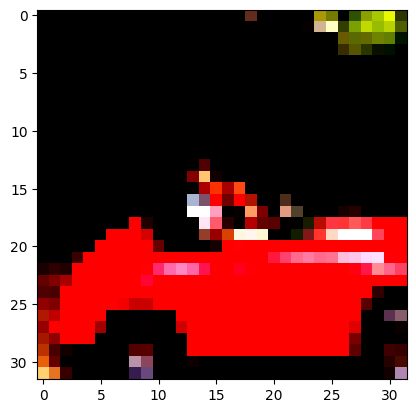

In [31]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()